In [14]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


def entropy_func(class_count: Counter, num_samples: int):
    entropy = 0
    for count in class_count.values():
        if count > 0:
            probability = count / num_samples
            entropy -= probability * math.log2(probability)
    return entropy


class Group:
    def __init__(self, group_classes):
        self.group_classes = group_classes
        self.entropy = self.group_entropy()

    def __len__(self):
        return len(self.group_classes)

    def group_entropy(self):
        class_count = Counter(self.group_classes)
        num_samples = len(self.group_classes)
        return entropy_func(class_count, num_samples)


class Node:
    def __init__(self, split_feature, split_val, depth=None, child_node_a=None, child_node_b=None, val=None):
        self.split_feature = split_feature
        self.split_val = split_val
        self.depth = depth
        self.child_node_a = child_node_a
        self.child_node_b = child_node_b
        self.val = val

    def predict(self, data):
        if self.val is not None:
            return self.val
        elif data[self.split_feature] <= self.split_val:
            return self.child_node_a.predict(data)
        else:
            return self.child_node_b.predict(data)


class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
        self.tree = None

    @staticmethod
    def get_split_entropy(group_a, group_b):
        total_samples = len(group_a) + len(group_b)
        entropy_a = group_a.entropy * len(group_a) / total_samples
        entropy_b = group_b.entropy * len(group_b) / total_samples
        return entropy_a + entropy_b

    def get_information_gain(self, parent_group, child_group_a, child_group_b):
        parent_entropy = parent_group.entropy
        split_entropy = self.get_split_entropy(child_group_a, child_group_b)
        return parent_entropy - split_entropy

    def get_best_feature_split(self, feature_values, classes):
        split_value = None
        max_information_gain = -1

        for value in feature_values:
            classes_a = []
            classes_b = []

            for i in range(len(feature_values)):
                if feature_values[i] <= value:
                    classes_a.append(classes[i])
                else:
                    classes_b.append(classes[i])

            information_gain = self.get_information_gain(Group(classes), Group(classes_a), Group(classes_b))

            if information_gain > max_information_gain:
                max_information_gain = information_gain
                split_value = value

        return split_value, max_information_gain


    def get_best_split(self, data, classes):
        split_feature = None
        split_value = None
        max_information_gain = -1

        for feature in range(len(data[0])):
            feature_values = [data[i][feature] for i in range(len(data))]
            curr_split_value, information_gain = self.get_best_feature_split(feature_values, classes)

            if information_gain > max_information_gain:
                max_information_gain = information_gain
                split_feature = feature
                split_value = curr_split_value

        return split_feature, split_value

    def build_tree(self, data, classes, depth=0):
        unique_classes = np.unique(classes)

        if depth == self.max_depth or len(unique_classes) == 1:
            return Node(split_feature=None, split_val=None, val=Counter(classes).most_common(1)[0][0])

        split_feature, split_value = self.get_best_split(data, classes)

        if split_feature is None:
            return Node(split_feature=None, split_val=None, val=Counter(classes).most_common(1)[0][0])

        data_a = []
        classes_a = []
        data_b = []
        classes_b = []

        for i in range(len(data)):
            if data[i][split_feature] <=  split_value:
                data_a.append(data[i])
                classes_a.append(classes[i])
            else:
                data_b.append(data[i])
                classes_b.append(classes[i])

        child_node_a = self.build_tree(data_a, classes_a, depth + 1)
        child_node_b = self.build_tree(data_b, classes_b, depth + 1)

        return Node(split_feature, split_value, depth, child_node_a, child_node_b)

    def create_tree(self, data, classes):
        self.tree = self.build_tree(data, classes)

    def predict(self, data):
        return self.tree.predict(data)




In [2]:
iris = load_iris()

x = iris.data
y = iris.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=123)


dt_classifier = DecisionTreeClassifier(3)
dt_classifier.create_tree(x_train, y_train)
for sample, gt in zip(x_test, y_test):
    prediction = dt_classifier.predict(sample)
    print(prediction, gt)

2 1
2 2
2 2
1 1
0 0
2 2
1 1
0 0
0 0
1 1
2 2
0 0
1 1
2 2
2 2


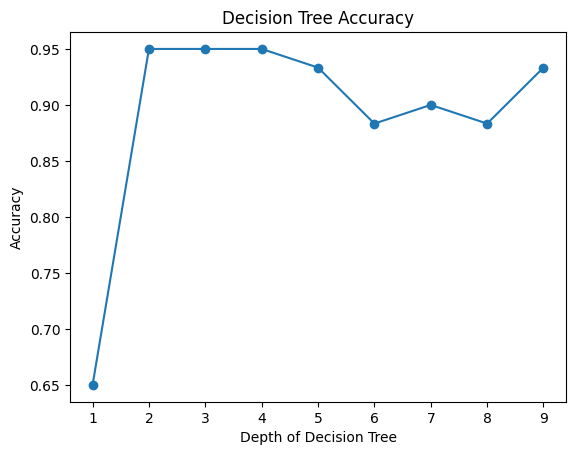

In [23]:
x = iris.data
y = iris.target


depths = list(range(1, 10))
accuracies = []

for i in range(1, 10):
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
  dt_classifier = DecisionTreeClassifier(i)
  dt_classifier.create_tree(x_train, y_train)
  predictions = []
  accurate = 0
  for sample, gt in zip(x_test, y_test):
    prediction = dt_classifier.predict(sample)
    predictions.append(dt_classifier.predict(sample))
    if gt == prediction:
      accurate += 1
  accuracies.append(accurate/len(predictions))
plt.plot(depths, accuracies, marker='o')
plt.title('Decision Tree Accuracy')
plt.xlabel('Depth of Decision Tree')
plt.ylabel('Accuracy')
plt.show()

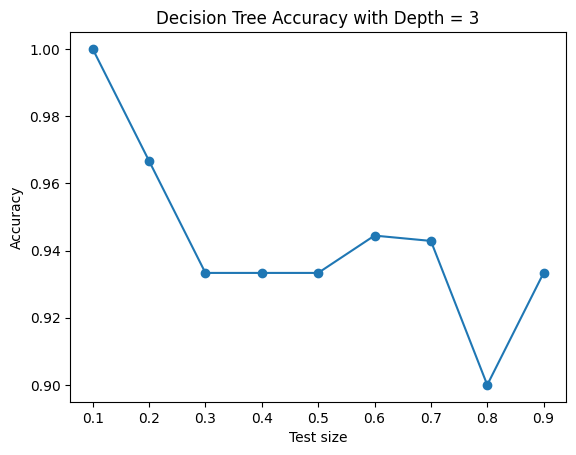

In [28]:
x = iris.data
y = iris.target


test_sizes = [i/10 for i in range(1, 10)]
accuracies = []

for i in test_sizes:
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=i)
  dt_classifier = DecisionTreeClassifier(3)
  dt_classifier.create_tree(x_train, y_train)
  predictions = []
  accurate = 0
  for sample, gt in zip(x_test, y_test):
    prediction = dt_classifier.predict(sample)
    predictions.append(dt_classifier.predict(sample))
    if gt == prediction:
      accurate += 1
  accuracies.append(accurate/len(predictions))
plt.plot(test_sizes, accuracies, marker='o')
plt.title('Decision Tree Accuracy with Depth = 3')
plt.xlabel('Test size')
plt.ylabel('Accuracy')
plt.show()